# Spectral Super Resolution Notebook

This notebook simulates the generation of realistic high-resolution astronomical spectra containing prominent lines such as H‑α, H‑β, [N II], [O II], and [O III]. It then degrades these spectra to lower resolution and trains a simple diffusion-based model (represented here by a convolutional neural network) to recover the high-resolution spectra. Finally, the notebook evaluates the model and plots the results to visually compare the true and predicted spectra.


Epoch 1/10, Loss: 37.8964
Epoch 2/10, Loss: 4.6839
Epoch 3/10, Loss: 3.3742
Epoch 4/10, Loss: 2.9170
Epoch 5/10, Loss: 2.8523
Epoch 6/10, Loss: 2.8250
Epoch 7/10, Loss: 2.8145
Epoch 8/10, Loss: 2.8090
Epoch 9/10, Loss: 2.8056
Epoch 10/10, Loss: 2.8035


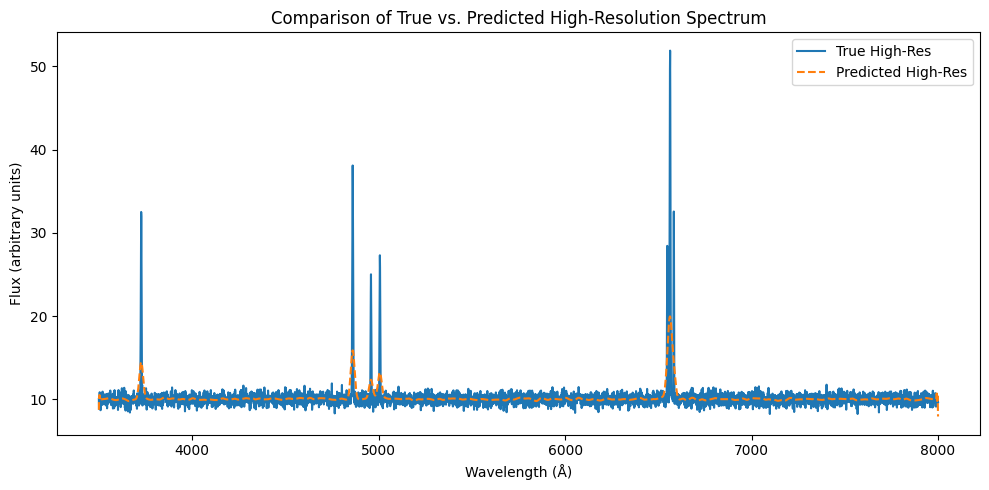

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# ---------------------------
# Step 1: Generate Simulated High-Res Spectra
# ---------------------------

def generate_high_res_spectrum(wavelengths, lines):
    """
    Generate a high-resolution spectrum with a continuum and Gaussian spectral lines.
    """
    continuum = np.ones_like(wavelengths) * 10  
    spectrum = continuum.copy()
    
    # Add Gaussian peaks for each spectral line
    for line_center, params in lines.items():
        # Vary amplitude and sigma slightly for realism
        amplitude = params['amplitude'] * np.random.uniform(0.8, 1.2)
        sigma = params['sigma'] * np.random.uniform(0.8, 1.2)
        spectrum += amplitude * np.exp(-0.5 * ((wavelengths - line_center) / sigma) ** 2)
    
    # Add a touch of noise
    noise = np.random.normal(0, 0.5, size=wavelengths.shape)
    return spectrum + noise

# Define key spectral lines with approximate centers (in Angstroms) and parameters
spectral_lines = {
    6563: {'amplitude': 50, 'sigma': 2},    # H-alpha
    4861: {'amplitude': 30, 'sigma': 2},    # H-beta
    6548: {'amplitude': 20, 'sigma': 1.5},  # [NII]
    6583: {'amplitude': 20, 'sigma': 1.5},  # [NII]
    3727: {'amplitude': 25, 'sigma': 2},    # [OII]
    4959: {'amplitude': 15, 'sigma': 2},    # [OIII]
    5007: {'amplitude': 15, 'sigma': 2},    # [OIII]
}

num_spectra = 300  # Generate a few hundred spectra
wavelengths = np.linspace(3500, 8000, 5000)  # High resolution wavelength grid
high_res_spectra = [generate_high_res_spectrum(wavelengths, spectral_lines) for _ in range(num_spectra)]
high_res_spectra = np.array(high_res_spectra)

# ---------------------------
# Step 2: Degrade Resolution to Simulate Low-Res Data
# ---------------------------

def degrade_resolution(spectrum, sigma_kernel=10):
    """
    Simulate a lower resolution spectrum by convolving with a Gaussian kernel.
    """
    return gaussian_filter1d(spectrum, sigma=sigma_kernel)

low_res_spectra = np.array([degrade_resolution(spec, sigma_kernel=10) for spec in high_res_spectra])

# ---------------------------
# Step 3: Prepare Data for Training & Evaluation
# ---------------------------

# Convert data to PyTorch tensors
high_res_tensor = torch.tensor(high_res_spectra, dtype=torch.float32)
low_res_tensor = torch.tensor(low_res_spectra, dtype=torch.float32)

dataset = TensorDataset(low_res_tensor, high_res_tensor)
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

# ---------------------------
# Step 4: Define a Simple (Placeholder) Diffusion-Based Model
# ---------------------------
# (Note: This simple CNN is just a stand-in. Real diffusion models involve iterative denoising steps.)

class SimpleDiffusionModel(nn.Module):
    def __init__(self):
        super(SimpleDiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=9, padding=4)
        )
    
    def forward(self, x):
        return self.net(x)

model = SimpleDiffusionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---------------------------
# Step 5: Train the Model
# ---------------------------

num_epochs = 10  # For demonstration; diffusion models may require many more epochs!
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for low_res_batch, high_res_batch in train_loader:
        # Add a channel dimension (batch, 1, spectrum_length)
        low_res_batch = low_res_batch.unsqueeze(1)
        high_res_batch = high_res_batch.unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(low_res_batch)
        loss = criterion(outputs, high_res_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * low_res_batch.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# ---------------------------
# Step 6: Evaluate & Plot Results
# ---------------------------

model.eval()
with torch.no_grad():
    # Get one batch from the evaluation set
    low_res_eval, high_res_eval = next(iter(eval_loader))
    low_res_eval = low_res_eval.unsqueeze(1)
    predictions = model(low_res_eval)

# Convert tensors to NumPy arrays for plotting
low_res_eval_np = low_res_eval.squeeze(1).cpu().numpy()
high_res_eval_np = high_res_eval.cpu().numpy()
predictions_np = predictions.squeeze(1).cpu().numpy()

# Plot one example from the evaluation set
sample_idx = 0
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, high_res_eval_np[sample_idx], label='True High-Res')
plt.plot(wavelengths, predictions_np[sample_idx], label='Predicted High-Res', linestyle='--')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (arbitrary units)')
plt.title('Comparison of True vs. Predicted High-Resolution Spectrum')
plt.legend()
plt.tight_layout()
plt.show()